Inspiration: 
https://medium.com/mlearning-ai/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-460b675a9cee

Vorgehen:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html


10000 Variablen: 
- Sonst HistGradientBoost besser, allerdings keine Quantile Forecasts

In [47]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame

energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")[-10000:]

energydata_xgb = extract_all_features.get_energy_and_features(
    energydata, feature_selection_comp=True)

2022-10-01 21:00:00
2023-11-23 12:00:00


Hyperparameter Tuning: 
* To find the best hyperparameters for your GradientBoostingRegressor, you can use a hyperparameter tuning approach
* One commonly used method is GridSearchCV or RandomizedSearchCV 
* scikit-learnscikit-learn's current version doesn't directly support quantile regression as a loss function in its grid search

--> create custom scorer for quantile loss and use it with GridSearchCV or RandomizedSearchCV

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

y = energydata[['energy_consumption']]
X = energydata.drop(columns=['energy_consumption'])

# Define the quantile loss function as a scorer
def pinball_loss_scorer(y_true, y_pred, alpha):
    errors = y_true - y_pred
    mask = errors < 0
    loss = alpha * np.sum(errors[mask]) + (1 - alpha) * np.sum(-errors[~mask])
    return loss / len(y_true)

# Define the parameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': list(range(5,15)),
    'min_samples_split': list(range(5,15))
}

# Create the time series split
tscv = TimeSeriesSplit(n_splits=5, test_size=100)
best_parameters = {}

for alpha in [0.025, 0.25, 0.5, 0.75, 0.975]:

    # Create a custom scorer for quantile loss
    quantile_scorer = make_scorer(
        pinball_loss_scorer, greater_is_better=False, alpha=alpha)
 
    # Create the GradientBoostingRegressor model
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha)

    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        gbr,
        param_distributions=param_grid,
        scoring=quantile_scorer,
        cv=tscv,
        n_iter=5,  # Adjust the number of iterations based on your computational resources
        random_state=42,
        verbose=1
    )

    # Fit the model
    random_search.fit(X, y.values.ravel())

    # Get the best hyperparameters
    best_params = random_search.best_params_

    print(f"Best Hyperparameters for {alpha}", best_params)
    best_parameters.update({alpha: best_params}) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters for 0.025 {'n_estimators': 300, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_depth': 4, 'learning_rate': 0.01}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters for 0.25 {'n_estimators': 300, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_depth': 4, 'learning_rate': 0.01}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters for 0.5 {'n_estimators': 300, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_depth': 4, 'learning_rate': 0.01}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters for 0.75 {'n_estimators': 300, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_depth': 4, 'learning_rate': 0.01}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters for 0.975 {'n_estimators': 300, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_depth': 4, 'learning_rate': 0.01}

Stadardized: {'n_estimators': 300, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_depth': 4, 'learning_rate': 0.01}
same with nonstandardized

## Model with selected parameters 

In [16]:
# Model with selected parameters
from sklearn.metrics import mean_pinball_loss
from sklearn.ensemble import GradientBoostingRegressor

y_train, y_test = energydata[['energy_consumption']
                             ][:-100], energydata[['energy_consumption']][-100:]
X_train, X_test = energydata.drop(columns=['energy_consumption'])[
    :-100], energydata.drop(columns=['energy_consumption'])[-100:]

optimized_params = dict(
    learning_rate=0.01,
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=13,
    min_samples_split=11,
)

predictions = pd.DataFrame()
pinball_losses = {}
for alpha in [0.025, 0.25, 0.5, 0.75, 0.975]:
    name = f'q{alpha}'
    gbr = GradientBoostingRegressor(
        loss="quantile", alpha=alpha, **optimized_params)
    quantile_model = gbr.fit(X_train, y_train)
    y_pred = quantile_model.predict(X_test)

    predictions[name] = y_pred
    pinball_losses.update(
        {name: mean_pinball_loss(y_test, y_pred, alpha=alpha)})

c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

In [17]:
pinball_losses

{'q0.025': 0.37452886597807755,
 'q0.25': 1.9132144834998506,
 'q0.5': 2.5031642330159216,
 'q0.75': 1.6388092831459609,
 'q0.975': 0.20488243919417257}

In [1]:
import pandas as pd
energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")
energydata = energydata[-10000:]
energydata

,energy_consumption
date_time,
2022-10-01 21:00:00,49.12975
2022-10-01 22:00:00,46.88900
2022-10-01 23:00:00,44.06500
2022-10-02 00:00:00,41.74750
2022-10-02 01:00:00,40.16575
...,...
2023-11-22 08:00:00,65.75125
2023-11-22 09:00:00,67.40950
2023-11-22 10:00:00,68.26775


In [50]:
10000/(365*24)

1.1415525114155252

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions.drop_years import drop_years
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame

optimized_params = dict(
    learning_rate=0.01,
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=13,
    min_samples_split=11,
)


def get_XGBoost_forecasts(energydata=np.nan, indexes=[47, 51, 55, 71, 75, 79], quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], periods=100, abs_eval = False):

    if type(energydata) == float:
        energydata = extract_energy_data.get_data(num_years=1.15) 

    if len(energydata) > 10000:
        energydata = extract_all_features.get_energy_and_features(
            energydata, feature_selection_comp=True)[-10000:]
    else: 
        energydata = extract_all_features.get_energy_and_features(
            energydata, feature_selection_comp=True)


    X = energydata.drop(columns=['energy_consumption'])
    y = energydata['energy_consumption']

    # create dataframe to store forecast quantiles
    energyforecast = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])

    X_pred = extract_all_features.get_energy_and_features(
        energyforecast, feature_selection_comp=True)

    X, X_pred = drop_years(X, X_pred)

    quantile_df = pd.DataFrame()
    for alpha in quantiles:
        name = f'q{alpha}'
        gbr = GradientBoostingRegressor(
            loss="quantile", alpha=alpha, **optimized_params)
        quantile_model = gbr.fit(X, y)
        y_pred = quantile_model.predict(X_pred)
        quantile_df[name] = y_pred

    quantile_df = quantile_df.iloc[indexes]

    # return quantile forecasts in terms of absolute evaluation
    if abs_eval == True:
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        quantile_df.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return quantile_df

    # else: create submission frame
    else:
        forecast_frame = create_submission_frame.get_frame(
            quantile_df, indexes)
        forecast_frame = forecast_frame.drop(columns={'index'})
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        forecast_frame.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return forecast_frame

In [6]:
energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")

In [7]:
forecasts = get_XGBoost_forecasts(energydata, indexes=list(range(20)), quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], abs_eval=True)
forecasts

2016-12-26 00:00:00
2023-11-23 12:00:00
2023-11-22 13:00:00
2023-11-27 16:00:00


,date_time,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9
0,2023-11-22 13:00:00,47.049800,50.453354,53.155781,55.908840,58.629428,61.327387,64.105631,65.941530,67.619107
1,2023-11-22 14:00:00,47.049800,50.453354,53.155781,55.908840,58.578557,60.472014,62.522923,65.185505,67.262433
2,2023-11-22 15:00:00,47.049800,50.453354,53.155781,55.908840,58.578557,60.472014,62.471099,65.185505,67.262433
3,2023-11-22 16:00:00,47.049800,50.453354,53.155781,55.908840,58.578557,60.472014,62.471099,65.185505,67.262433
4,2023-11-22 17:00:00,47.049800,50.453354,53.155781,55.908840,58.578557,60.472014,63.692922,65.859312,67.909736
5,2023-11-22 18:00:00,47.049800,50.453354,53.155781,55.908840,58.578557,60.472014,63.604615,66.651642,68.087330
6,2023-11-22 19:00:00,47.049800,50.453354,53.155781,55.908840,58.578557,60.472014,63.061939,65.528788,67.262433
7,2023-11-22 20:00:00,47.049800,50.453354,53.155781,55.908840,58.578557,60.472014,62.471099,65.185505,67.262433
8,2023-11-22 21:00:00,47.049800,50.453354,53.155781,55.908840,58.578557,60.472014,62.471099,65.185505,67.262433
9,2023-11-22 22:00:00,47.049800,50.453354,53.155781,55.325589,56.598150,59.003904,62.471099,65.185505,67.262433


Maybe: Try out different parameters

Forecast Calibration

In [26]:
from energy_consumption.feature_selection.clean.impute_outliers import impute_outliers
energydata_hist = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata_hist['date_time'] = pd.to_datetime(
    energydata_hist['date_time'], format='%Y-%m-%d %H:%M:%S')

energydata_hist = energydata_hist.set_index("date_time")
energydata_hist = energydata_hist[-10000:]
energydata_hist = impute_outliers(energydata_hist)


In [33]:
idx_max = energydata_hist.index.max()
idx_max

Timestamp('2023-11-22 12:00:00')

In [1]:
from energy_consumption.feature_selection.extract import extract_energy_data
energydata = extract_energy_data.get_data(num_years=1.14)

100%|██████████| 59/59 [00:40<00:00,  1.46it/s]


In [37]:
energydata[idx_max:]

,energy_consumption
date_time,
2023-11-22 12:00:00,69.28725
2023-11-22 13:00:00,67.89025
2023-11-22 14:00:00,66.70475
2023-11-22 15:00:00,66.70325
2023-11-22 16:00:00,67.77650
...,...
2024-01-17 08:00:00,72.40200
2024-01-17 09:00:00,73.08200
2024-01-17 10:00:00,72.98150


In [3]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
 'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# exactly 8 weekly rounds from energydata_hist to new data 
for i in range(1, 8):
    print(f'start of round {i}') 
    forecasts = get_XGBoost_forecasts(energydata[:i*(-168)], 
                                      indexes=list(range(100)), 
                                      quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+100].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

start of round 1


C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df.loc[:, 'hour'] = energy_df.index.hour
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df[name] = np.where(energy_df['hour'] == h, 1, 0)
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumpti

2022-12-12 00:00:00
2024-01-18 12:00:00
2024-01-17 13:00:00
2024-01-22 16:00:00
start of round 2


C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df.loc[:, 'hour'] = energy_df.index.hour
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df[name] = np.where(energy_df['hour'] == h, 1, 0)
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumpti

2022-12-12 00:00:00
2024-01-11 12:00:00
2024-01-10 13:00:00
2024-01-15 16:00:00
start of round 3


C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df.loc[:, 'hour'] = energy_df.index.hour
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df[name] = np.where(energy_df['hour'] == h, 1, 0)
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumpti

2022-12-12 00:00:00
2024-01-04 12:00:00
2024-01-03 13:00:00
2024-01-08 16:00:00
start of round 4


C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df.loc[:, 'hour'] = energy_df.index.hour
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df[name] = np.where(energy_df['hour'] == h, 1, 0)
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumpti

2022-12-12 00:00:00
2023-12-28 12:00:00
2023-12-27 13:00:00
2024-01-01 16:00:00
start of round 5


C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df.loc[:, 'hour'] = energy_df.index.hour
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df[name] = np.where(energy_df['hour'] == h, 1, 0)
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumpti

2022-12-12 00:00:00
2023-12-21 12:00:00
2023-12-20 13:00:00
2023-12-25 16:00:00
start of round 6


C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df.loc[:, 'hour'] = energy_df.index.hour
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df[name] = np.where(energy_df['hour'] == h, 1, 0)
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumpti

2022-12-12 00:00:00
2023-12-14 12:00:00
2023-12-13 13:00:00
2023-12-18 16:00:00
start of round 7


C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df.loc[:, 'hour'] = energy_df.index.hour
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\feature_selection\collect\dummy_mapping.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_df[name] = np.where(energy_df['hour'] == h, 1, 0)
C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumpti

2022-12-12 00:00:00
2023-12-07 12:00:00
2023-12-06 13:00:00
2023-12-11 16:00:00


In [1]:
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))
pit_merged

NameError: name 'pit_merged' is not defined

In [43]:
import matplotlib.pyplot as plt

def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'

# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()


quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())
ordered_quantile_counts

{0.1: 73,
 0.2: 77,
 0.3: 74,
 0.4: 63,
 0.5: 68,
 0.6: 70,
 0.7: 64,
 0.8: 73,
 0.9: 77,
 1: 61}

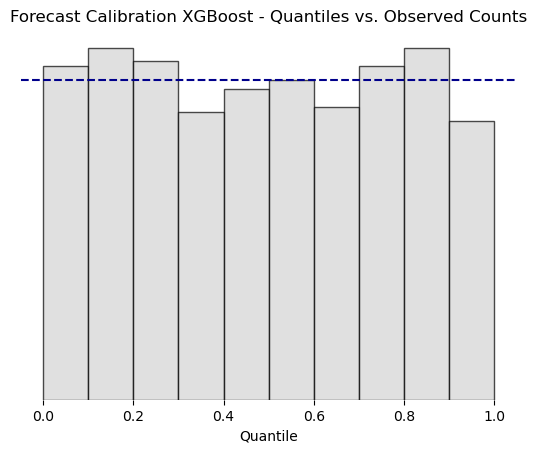

In [46]:
import matplotlib.pyplot as plt

bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Calculate the mean of the y-values
mean_value = sum(counts) / len(counts)

# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])

 # Plot mean
plt.axhline(y=mean_value, color='darkblue', linestyle='--', label='Mean')


# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration XGBoost - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()